In [1]:
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators')
import matplotlib.pyplot as plt
from utils.shabanipy.labber import LabberData

import numpy as np
from utils.jy_mpl_settings.settings import jy_mpl_rc
from utils.jy_mpl_settings.colors import line_colors
import utils.qubit_functions as qf
plt.style.use(jy_mpl_rc)

root = '/Users/billystrickland/Documents/code/resonators/devices/fluxonium/paper_figures/data'

In [2]:
sample = 'JS681-4fluxonium-005'
cooldown = '003'
people = 'BS'
file_num = '278'

FILE = f'{root}/{sample}-{cooldown}-{people}-{file_num}.hdf5'

# Define channels for I, Q, and time
I_CH, Q_CH, T_CH = ['Digitizer ShabLab - Ch3 - Signal',
                     'Digitizer ShabLab - Ch4 - Signal',
                     'MQPG - Readout delay',]

# Extract data using LabberData context
with LabberData(FILE) as f:
    I = f.get_data(I_CH)  # Extract I data
    Q = f.get_data(Q_CH)  # Extract Q data
    time = f.get_data(T_CH)  # Extract time data


T1 = 78.4 +- 4.1 ns


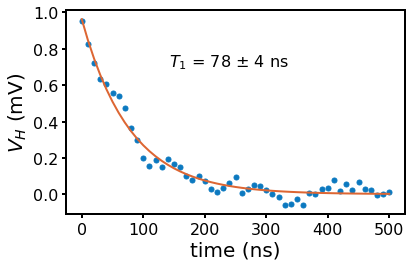

In [4]:
from scipy.optimize import curve_fit

# Define exponential decay function
def exp_decay(t, T1, A, b):
    return A*np.exp(-t/T1)+b

# Fit decay function to the signal
def fit_decay(time, signal, plot_fit=True, voltage=False, p0=[100, 1, 1]):
    popt, pcov = curve_fit(exp_decay, time, signal, p0=p0, maxfev=500000000)
    a = popt  # Optimal parameters
    perr = np.sqrt(np.diag(pcov))  # Parameter uncertainties
    return a, perr

# Extract signal and process it
signal = np.mean(Q[:, 30:100], axis=1)
signal = (signal*1e3)*.9 + 19.8  # Adjust units and apply scaling

# Fit the decay and print results
results = fit_decay(time*1e9, signal, plot_fit=True, voltage=True)
print(f'T1 = {results[0][0]:.1f} +- {results[1][0]:.1f} ns')

# Plot the signal and fitted decay curve
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(time*1e9, signal, marker='.', linestyle='None')
plt.plot(time*1e9, exp_decay(time*1e9, results[0][0], results[0][1], results[0][2]))
plt.ylabel('$V_H$ (mV)')
plt.xlabel('time (ns)')
plt.annotate(f'$T_1$ = {int(results[0][0])} $\pm$ {int(results[1][0])} ns', 
             xy=(.41, .75), xycoords='figure fraction', fontsize=16)
fig.tight_layout()

# Save the figure
plt.savefig(f'figs_final/fig5b_inset.pdf', format='pdf')
